In [ ]:
import pandas as pd
import numpy as np
import seaborn as sns
#from sklearn.model_selection import TimeSeriesSplit
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import LSTM, Dense, Dropout
from tensorflow.keras.losses import BinaryFocalCrossentropy
from tensorflow.keras.metrics import Precision, Recall, AUC
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler

In [2]:
data = pd.read_csv("epl_event_data_15.csv")

## assess popularity of event types

C:\Users\conny\AppData\Local\Temp\ipykernel_12040\3324669436.py:2: UserWarning: set_ticklabels() should only be used with a fixed number of ticks, i.e. after set_ticks() or using a FixedLocator.
  hist.set_xticklabels(hist.get_xticklabels(), rotation=90)


[Text(0, 0, 'Starting XI'),
 Text(1, 0, 'Half Start'),
 Text(2, 0, 'Pass'),
 Text(3, 0, 'Ball Receipt*'),
 Text(4, 0, 'Carry'),
 Text(5, 0, 'Pressure'),
 Text(6, 0, 'Dispossessed'),
 Text(7, 0, 'Duel'),
 Text(8, 0, 'Shot'),
 Text(9, 0, 'Block'),
 Text(10, 0, 'Goal Keeper'),
 Text(11, 0, 'Ball Recovery'),
 Text(12, 0, 'Miscontrol'),
 Text(13, 0, 'Clearance'),
 Text(14, 0, 'Dribbled Past'),
 Text(15, 0, 'Dribble'),
 Text(16, 0, 'Interception'),
 Text(17, 0, 'Foul Committed'),
 Text(18, 0, 'Foul Won'),
 Text(19, 0, 'Half End'),
 Text(20, 0, 'Substitution'),
 Text(21, 0, 'Injury Stoppage'),
 Text(22, 0, 'Tactical Shift'),
 Text(23, 0, 'Shield'),
 Text(24, 0, '50/50'),
 Text(25, 0, 'Offside'),
 Text(26, 0, 'Error'),
 Text(27, 0, 'Bad Behaviour'),
 Text(28, 0, 'Referee Ball-Drop'),
 Text(29, 0, 'Own Goal Against'),
 Text(30, 0, 'Own Goal For'),
 Text(31, 0, 'Player Off'),
 Text(32, 0, 'Player On')]

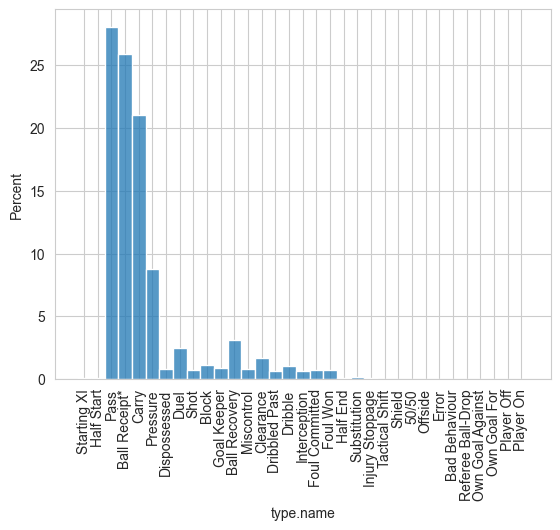

In [8]:
hist = sns.histplot(data=data, x="type.name", stat="percent")
hist.set_xticklabels(hist.get_xticklabels(), rotation=90)

In [ ]:

#timestamp in time format
data.timestamp = pd.to_datetime(data.timestamp)

In [ ]:

main_df = pd.DataFrame(data)


main_df['sort_priority'] = main_df['type.name'].map({
    'Ball Receipt*': 0,
    "Ball Recovery":1,  
    'Pass': 2,
    "Foul Won":10
    
    
}).fillna(9)#give all others 9 priority (better than foul won)

# Sort with priority
main_df = main_df.sort_values(['match_id', 'timestamp', 'sort_priority'])


# Mark all Ball Receipt events
main_df['is_br'] = ((main_df['type.name'] == 'Ball Receipt*')|(main_df['type.name'] == 'Ball Recovery')).astype(int)

# Create possession groups
main_df['poss_group'] = main_df['is_br'].cumsum()

# Forward-fill player.id within each possession group
main_df['possessing_player'] = (main_df['player.id']
                               .where(main_df['is_br'] == 1)
                               .groupby(main_df['poss_group'])
                               .ffill())

# Detect possession endings (Pass or new Ball Receipt)
end_conditions = (
    ((main_df['type.name'] == 'Pass') & 
    (main_df['player.id'] == main_df['possessing_player'])) | \
    ((main_df['type.name'] == 'Ball Receipt*') & 
    (main_df['player.id'] != main_df['possessing_player']))    | \
    ((main_df['type.name'] == 'Ball Recovery') & 
    (main_df['player.id'] != main_df['possessing_player'])))

# Create valid possession windows
main_df['valid_possession'] = (main_df['poss_group']
                              .isin(main_df.loc[end_conditions, 'poss_group'] - 1))

main_df['in_possession'] = (
    (main_df['possessing_player'].notna())
    .astype(int)
)
# Cleanup
main_df = main_df.drop(columns=['is_br', 'poss_group', 'valid_possession'])


                     timestamp    type.name  player.id  in_possession  \
88194  2025-04-26 00:00:00.000  Starting XI        NaN              0   
88195  2025-04-26 00:00:00.000  Starting XI        NaN              0   
88196  2025-04-26 00:00:00.000   Half Start        NaN              0   
88197  2025-04-26 00:00:00.000   Half Start        NaN              0   
89966  2025-04-26 00:00:00.000   Half Start        NaN              0   
...                        ...          ...        ...            ...   
556453 2025-04-26 00:48:55.036        Carry     7780.0              1   
556454 2025-04-26 00:48:56.196         Pass     7780.0              1   
556455 2025-04-26 00:48:57.675    Clearance     3407.0              1   
556456 2025-04-26 00:49:01.683     Half End        NaN              1   
556457 2025-04-26 00:49:01.683     Half End        NaN              1   

        possessing_player  
88194                 NaN  
88195                 NaN  
88196                 NaN  
88197      

### get unique id for each player possession

In [ ]:
change_mask = (
    #if a player is newly in possession
    (main_df['in_possession'].diff() != 0) | 
    #or player in possession has changed
    (main_df['possessing_player'] != main_df['possessing_player'].shift())
)

#Generate possession identifiers
main_df['poss_identifier'] = (
    change_mask.cumsum() * main_df['in_possession']
).astype(int)



In [ ]:
main_df['move_number'] = main_df.groupby('poss_identifier').cumcount() + 1

# Identify first/last moves in possession
main_df['first_move'] = main_df['move_number'] == 1
main_df['last_move'] = False

# For last move look ahead to the next row
last_moves = main_df.groupby('poss_identifier')['timestamp'].idxmax()
main_df.loc[last_moves, 'last_move'] = True

tensor containing pressure, distance, duration, dribble, dribble past

### get features

In [ ]:
main_df["pressure"] = np.where(main_df["under_pressure"],1,0)
main_df["dribble"] = np.where(main_df["type.name"]=="dribble",1,0)
main_df["dribble_past"] = np.where(main_df["type.name"]=="dribble.past",1,0)
#put events in index order, to get correct durations for each event
main_df= main_df.sort_values(["match_id", "index"])
#get duration of each event to the next one
main_df['duration_seconds'] =main_df["timestamp"].diff().dt.total_seconds().fillna(0).astype(float)



In [19]:
main_df['y'] = (main_df.groupby('poss_identifier')['type.name']
            .transform(lambda x: x.eq('Foul Won').any().astype(int)))
main_df = main_df[main_df["type.name"]!="Foul Won"]
# 2. For non-possession rows (poss_identifier=0), set y=0
main_df.loc[main_df['poss_identifier'] == 0, 'y'] = 0

In [ ]:
def create_balanced_sequences(df, window_size=4):
    sequences = []
    labels = []
    
    # Group by possession identifier
    for pid, group in df.groupby('poss_identifier'):
        if pid == 0:  # Skip non-possession rows
            continue
            
        y = group['y'].iloc[0]  # Get possession label
        possession_events = group.sort_values('timestamp')
        n_events = len(possession_events)
        
        if y == 1:
            # For foul possessions: take last 3 events before foul
            if n_events >= window_size:
                window = possession_events.iloc[-window_size:]
                seq_features = window[['pressure', 'dribble', 'dribble_past', 'duration_seconds']].values.flatten()
                sequences.append(seq_features)
                labels.append(1)
                
        else:
            # For non-foul possessions: random 3-event sequence
            if n_events >= window_size:
                # Generate up to 3 random sequences per possession for balance
                for _ in range(4 if n_events > 6 else 1):
                    start_idx = np.random.randint(0, n_events - window_size + 1)
                    window = possession_events.iloc[start_idx:start_idx+window_size]
                    seq_features = window[['pressure', 'dribble', 'dribble_past', 'duration_seconds']].values.flatten()
                    sequences.append(seq_features)
                    labels.append(0)
    
    return np.array(sequences), np.array(labels)

In [ ]:

X, y = create_balanced_sequences(main_df)


# Reshape for LSTM (samples, timesteps, features)
X_reshaped = X.reshape((X.shape[0], 4, 4))  # 4 timesteps, 4 features per event

# 3. Train/Test Split ----------------------------------------------------------
X_train, X_test, y_train, y_test = train_test_split(
    X_reshaped, y, test_size=0.2, stratify=y, random_state=42
)
X_train, X_val, y_train, y_val = train_test_split(
    X_reshaped, y, test_size=0.25, stratify=y, random_state=43
)


# Scale per-feature
scaler = StandardScaler()
X_train_scaled = scaler.fit_transform(X_train.reshape(-1, 4)).reshape(X_train.shape)
X_val_scaled = scaler.fit_transform(X_val.reshape(-1, 4)).reshape(X_val.shape)
X_test_scaled = scaler.transform(X_test.reshape(-1, 4)).reshape(X_test.shape)


In [ ]:

#X, y = create_balanced_sequences(main_df)

# Reshape for LSTM (samples, timesteps, features)
#X_reshaped = X.reshape((X.shape[0], 4, 4))  # 4 timesteps, 4 features per event

# Train/Test Split
#X_train, X_test, y_train, y_test = train_test_split(
#    X_reshaped, y, test_size=0.2, stratify=y, random_state=42
#)

# Scale per-feature
#scaler = StandardScaler()
#X_train_scaled = scaler.fit_transform(X_train.reshape(-1, 4)).reshape(X_train.shape)
#X_val_scaled = scaler.fit_transform(X_val.reshape(-1, 4)).reshape(X_val.shape)
#X_test_scaled = scaler.transform(X_test.reshape(-1, 4)).reshape(X_test.shape)

# 5. Build LSTM Model ----------------------------------------------------------
model = Sequential([
    LSTM(64, input_shape=(4, 4), return_sequences=True, recurrent_dropout=0.2),
    Dropout(0.3),
    LSTM(32, recurrent_dropout=0.2),
    Dense(16, activation='relu'),
    Dropout(0.2),
    Dense(1, activation='sigmoid')
])

model.compile(
    loss=BinaryFocalCrossentropy(gamma=2),#'binary_crossentropy',
    optimizer='adam',
    metrics=[Precision(name='precision'),
        Recall(name='recall'),
        AUC(name='pr_auc', curve='PR'), ]#['binary_accuracy', 'Precision', 'Recall']
)

# 6. Train with Class Weighting -------------------------------------------------
class_weights = {0: 1, 1: 0.25
                 *(len(y_train[y_train==0])/len(y_train[y_train==1]))}  # Auto-balance
history = model.fit(
    X_train_scaled, y_train,
    epochs=20,
    batch_size=32,
    #validation_split=0.2,
    validation_data=(X_val_scaled, y_val),
    class_weight=class_weights
)

# 7. Evaluate -------------------------------------------------------------------
results = model.evaluate(X_test_scaled, y_test)
print(f"Test Loss: {results[0]:.3f}")
print(f"Test Precision: {results[1]:.3f}")
print(f"Test Recall: {results[2]:.3f}")
print(f"Test AUC-PR: {results[3]:.3f}")

Epoch 1/20


C:\Users\conny\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\keras\src\layers\rnn\rnn.py:200: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


4954/4954 ━━━━━━━━━━━━━━━━━━━━ 31s 5ms/step - loss: 0.1524 - pr_auc: 0.0705 - precision: 0.1298 - recall: 0.0389 - val_loss: 0.0648 - val_pr_auc: 0.1083 - val_precision: 0.1609 - val_recall: 0.1433
Epoch 2/20
4954/4954 ━━━━━━━━━━━━━━━━━━━━ 27s 5ms/step - loss: 0.1420 - pr_auc: 0.1044 - precision: 0.1582 - recall: 0.1275 - val_loss: 0.0654 - val_pr_auc: 0.1141 - val_precision: 0.1527 - val_recall: 0.1397
Epoch 3/20
4954/4954 ━━━━━━━━━━━━━━━━━━━━ 28s 6ms/step - loss: 0.1408 - pr_auc: 0.1106 - precision: 0.1712 - recall: 0.1494 - val_loss: 0.0654 - val_pr_auc: 0.1318 - val_precision: 0.2094 - val_recall: 0.1866
Epoch 4/20
4954/4954 ━━━━━━━━━━━━━━━━━━━━ 29s 6ms/step - loss: 0.1374 - pr_auc: 0.1298 - precision: 0.2034 - recall: 0.1929 - val_loss: 0.0723 - val_pr_auc: 0.1564 - val_precision: 0.2099 - val_recall: 0.3119
Epoch 5/20
4954/4954 ━━━━━━━━━━━━━━━━━━━━ 32s 7ms/step - loss: 0.1360 - pr_auc: 0.1515 - precision: 0.2258 - recall: 0.2356 - val_loss: 0.0673 - val_pr_auc: 0.1618 - val_preci

1239/1239 ━━━━━━━━━━━━━━━━━━━━ 3s 2ms/step


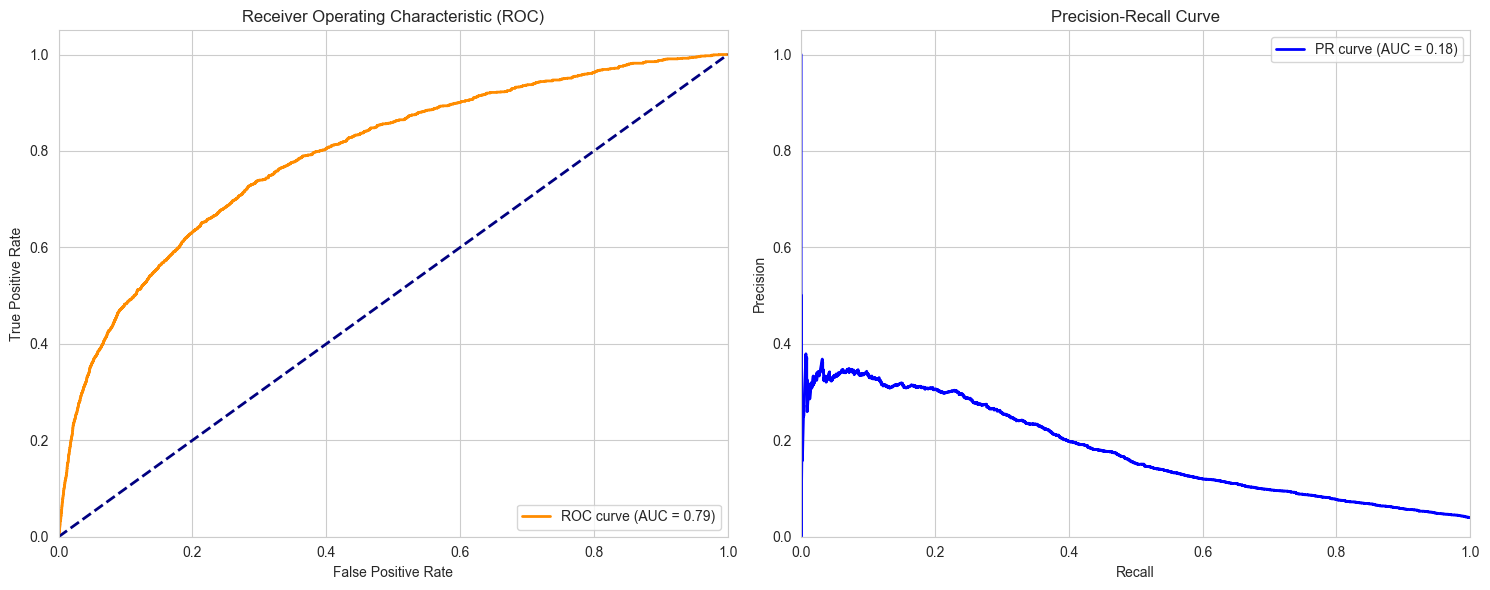

In [38]:
import matplotlib.pyplot as plt
from sklearn.metrics import roc_curve, auc, precision_recall_curve, average_precision_score

# Get predicted probabilities
y_probs = model.predict(X_test_scaled).ravel()

# Calculate ROC curve
fpr, tpr, thresholds_roc = roc_curve(y_test, y_probs)
roc_auc = auc(fpr, tpr)

# Calculate Precision-Recall curve
precision, recall, thresholds_pr = precision_recall_curve(y_test, y_probs)
pr_auc = average_precision_score(y_test, y_probs)

# Create subplots
fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(15, 6))

# Plot ROC Curve
ax1.plot(fpr, tpr, color='darkorange', lw=2, label=f'ROC curve (AUC = {roc_auc:.2f})')
ax1.plot([0, 1], [0, 1], color='navy', lw=2, linestyle='--')
ax1.set_xlim([0.0, 1.0])
ax1.set_ylim([0.0, 1.05])
ax1.set_xlabel('False Positive Rate')
ax1.set_ylabel('True Positive Rate')
ax1.set_title('Receiver Operating Characteristic (ROC)')
ax1.legend(loc="lower right")

# Plot Precision-Recall Curve
ax2.plot(recall, precision, color='blue', lw=2, label=f'PR curve (AUC = {pr_auc:.2f})')
ax2.set_xlim([0.0, 1.0])
ax2.set_ylim([0.0, 1.05])
ax2.set_xlabel('Recall')
ax2.set_ylabel('Precision')
ax2.set_title('Precision-Recall Curve')
ax2.legend(loc="upper right")

plt.tight_layout()
plt.show()